In [ ]:
import numpy as np
import os
import cv2
import csv
import matplotlib.pyplot as plt
import math
import sys
import scipy.io
from scipy.interpolate import griddata
import time
from itertools import product, combinations
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mtick
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

1.15.2


In [ ]:
np.random.seed(1234)
tf.set_random_seed(1234)

In [ ]:
def initial_learning_rate(epoch):
    if (epoch >= 0) and (epoch < 500):
        return 0.01
    if (epoch >= 500) and (epoch < 1000):
        return 0.001
    else:
        return 0.0001

In [ ]:
class PDENet:
    # Init
    def __init__(self, xb, yb, tb, ub, xi, yi, ti, ui, x, y, t, layers):
        
        self.dim = 3
        
        self.xb = xb
        self.yb = yb
        self.tb = tb
        self.ub = ub
        self.xi = xi
        self.yi = yi
        self.ti = ti
        self.ui = ui
        self.x = x
        self.y = y
        self.t = t
        self.layers = layers
        
        # Initialize NN
        self.weights, self.biases = self.init_NN(layers)
        
        # Initialize parameters
        # self.lambda_1 = tf.Variable([0.0], dtype=tf.float32)
        # self.lambda_2 = tf.Variable([0.0], dtype=tf.float32)
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        self.xytb_tf = tf.placeholder(tf.float32, shape=[None, 3, 1])
        self.ub_tf = tf.placeholder(tf.float32, shape=[None, 1])

        self.xyti_tf = tf.placeholder(tf.float32, shape=[None, 3, 1])
        self.ui_tf = tf.placeholder(tf.float32, shape=[None, 1])

        self.xyt_tf = tf.placeholder(tf.float32, shape=[None, 3, 1])

        self.ub_pred, _ , _ , _ = self.net_u(self.xytb_tf)
        self.ui_pred, _ , _ , _ = self.net_u(self.xyti_tf)
        _ , self.f_u_pred = self.net_f_u(self.xyt_tf)
        
        self.loss = tf.reduce_mean(tf.square(self.ub_tf - self.ub_pred)) + \
                    tf.reduce_mean(tf.square(self.ui_tf - self.ui_pred)) + \
                    tf.reduce_mean(tf.square(self.f_u_pred))
                    
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 3000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})    
        self.lossHistogram = []  
        # self.adaptive_rate = tf.placeholder(tf.float32)
        self.optimizer_Adam = tf.train.AdamOptimizer(learning_rate= 0.001)
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)                  
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def init_NN(self, layers):
        dim = self.dim
        weights = []
        biases = []
        num_layers = len(layers)
        W = self.xavier_init(size=[layers[0], dim])
        b = tf.Variable(tf.zeros([layers[0],1], dtype=tf.float32), dtype=tf.float32)
        weights.append(W)  
        biases.append(b)
        for l in range(1,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l]])
            b = tf.Variable(tf.zeros([layers[l],1], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)  
        W = self.xavier_init(size=[1, layers[-1]])
        b = tf.Variable(tf.zeros([1,1], dtype=tf.float32), dtype=tf.float32)
        weights.append(W)  
        biases.append(b) 
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def net_nn(self, X, weights, biases):
        num_layers = len(self.layers)
        S = X
        for l in range(0,num_layers-1):
            W = weights[l]
            b = biases[l]
            S = tf.tanh(tf.add(tf.matmul(W, S), b))
        W = weights[-1]
        b = biases[-1]
        S = tf.add(tf.matmul(W, S), b)
        return S

    def net_u(self, xyt):
        u = self.net_nn(xyt, self.weights, self.biases)
        u = u[:,0]
        grad = tf.gradients(u, xyt)[0]
        u_x = grad[:,0]
        u_y = grad[:,1]
        u_t = grad[:,2]
        return u, u_x, u_y, u_t
        
    def net_f_u(self, xyt):
        u, u_x, u_y, u_t = self.net_u(xyt)

        u_xx = tf.gradients(u_x, xyt)[0][:,0]
        u_yy = tf.gradients(u_y, xyt)[0][:,1]

        f_u = u_t - (u_xx + u_yy) - (1+2.0*np.pi*np.pi)*tf.math.exp(xyt[:,2])*tf.math.sin(np.pi*xyt[:,0])*tf.math.sin(np.pi*xyt[:,1])
        
        return u, f_u
    
    def callback(self, loss):
        print('Loss: %.3e' % (loss))
        self.lossHistogram.append(loss)
      
    def train(self, nIter): 

        tf_dict = {self.xytb_tf: np.concatenate([self.xb, self.yb, self.tb], 1), self.ub_tf: self.ub,
                   self.xyti_tf: np.concatenate([self.xi, self.yi, self.ti], 1), self.ui_tf: self.ui,
                   self.xyt_tf: np.concatenate([self.x, self.y, self.t], 1)}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            # if it % 10 == 0:
            elapsed = time.time() - start_time
            loss_value = self.sess.run(self.loss, tf_dict)
            print('It: %d, Loss: %.3e, Time: %.2f' % 
                    (it, loss_value, elapsed))
            self.lossHistogram.append(loss_value)
            start_time = time.time()

        self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss],
                                loss_callback = self.callback)
    
    def predict(self, x, y, t):
        
        tf_dict = {self.xytb_tf: np.concatenate([x, y, t], 1)}
        
        u = self.sess.run(self.ub_pred, tf_dict)

        # tf_dict = {self.x_tf: x, self.y_tf: y}
        
        # f_u = self.sess.run(self.f_u_pred, tf_dict)
        
        return u

In [ ]:
class sampling_from_rectangle:
    def __init__(self, x_range, y_range, t_range):
        self.x_range = x_range
        self.y_range = y_range
        self.t_range = t_range

    def initial_samples(self, batchsize):
        # batchsize = int(batchsize/10)
        init_draw_x = np.random.uniform(self.x_range[0], self.x_range[1], batchsize)
        init_draw_y = np.random.uniform(self.y_range[0], self.y_range[1], batchsize)
        init_draw_t = np.random.uniform(self.t_range[0], self.t_range[0], batchsize)

        return init_draw_x, init_draw_y, init_draw_t

    def interior_samples(self, batchsize):
        int_draw_x = np.random.uniform(self.x_range[0], self.x_range[1], batchsize)
        int_draw_y = np.random.uniform(self.y_range[0], self.y_range[1], batchsize)
        int_draw_t = np.random.uniform(self.t_range[0], self.t_range[1], batchsize)

        return int_draw_x, int_draw_y, int_draw_t

    def boundary_samples(self, batchsize):
        # batchsize = int(batchsize/3)
        a = self.x_range[1]-self.x_range[0]
        b = self.y_range[1]-self.y_range[0]

        draw_perimeter = np.random.uniform(0, 2*(a + b), batchsize)

        draw = []

        for i in draw_perimeter:
            if i < a:
                draw.append([i+ self.x_range[0], self.y_range[0]])
            elif a <= i and i < a+b:
                draw.append([self.x_range[1], (i-a) + self.y_range[0]])
            elif a+b <= i and i < 2*a+b:
                draw.append([self.x_range[1] - (i-(a+b)), self.y_range[1]])
            elif 2*a+b <= i and i<= 2*a+2*b:
                draw.append([self.x_range[0], self.y_range[1] - (i-(2*a+b))])

        bound_draw_t = np.random.uniform(self.t_range[0], self.t_range[1], batchsize)
        return np.array(draw)[:, 0], np.array(draw)[:, 1], bound_draw_t

In [ ]:
sampler = sampling_from_rectangle([0.0, 1.0], [0.0, 1.0], [0.0, 1.0])
N = 2000;
filename = 'data_'

with open(filename + str(N) + '.csv', mode='w') as f:
    csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    bou_draw_x, bou_draw_y, bou_draw_t = sampler.boundary_samples(N)
    int_draw_x, int_draw_y, int_draw_t = sampler.interior_samples(N)
    init_draw_x, init_draw_y, init_draw_t = sampler.initial_samples(N)
    
    for i in range(N):
        csv_writer.writerow([int_draw_x[i], int_draw_y[i], int_draw_t[i],
                             bou_draw_x[i], bou_draw_y[i], bou_draw_t[i], 0.0, 
                             init_draw_x[i], init_draw_y[i], init_draw_t[i], np.sin(np.pi*init_draw_x[i])*np.sin(np.pi*init_draw_y[i])])

dataset = np.genfromtxt('data_2000.csv', delimiter=',')
print(dataset)

[[0.58900704 0.44933121 0.21799792 ... 0.74865871 0.         0.70654502]
 [0.42786014 0.96243047 0.10662169 ... 0.91409094 0.         0.04547773]
 [0.85409391 0.6633909  0.95711985 ... 0.3066197  0.         0.60325935]
 ...
 [0.85437496 0.8352649  0.74123133 ... 0.45985962 0.         0.14423915]
 [0.15776623 0.94465303 0.27648917 ... 0.72699333 0.         0.75341154]
 [0.75415449 0.57808173 0.15503294 ... 0.850605   0.         0.26975895]]


In [ ]:
dataset[0]

array([0.84518147, 0.86138164, 0.77991124, 0.72351165, 0.        ,
       0.62776126, 0.        , 0.65210576, 0.0281263 , 0.        ,
       0.07836141])

In [ ]:
def flatArr(x):
    y = []
    for row in x:
        for el in row:
            y.append(el)
    return np.array(y).flatten()

def splitData(data):
    x = []
    y = []
    xb = []
    yb = []
    ub = []
    u = []
    for row in data:
        if (row[0] == 0. or row[1] == 0. or row[0] == 1. or row[1] == 1.):
            xb.append(row[0])
            yb.append(row[1])
            ub.append(0.0)
        else:
            x.append(row[0])
            y.append(row[1])
            u.append(round(np.sin(np.pi*row[0])*np.sin(np.pi*row[1]), 6))
    return np.array(x), np.array(y), np.array(u), np.array(xb), np.array(yb), np.array(ub)

def sample(T, delta_t, data):
    xi,yi,ui,xb,yb,ub = splitData(data)
    x_arr = np.array([])
    y_arr = np.array([])
    NT = np.int(T/delta_t)
    t = []
    for i in range(NT):
        t.append([round((i+1)*delta_t,6) for e in range(xi.size)])
        x_arr = np.concatenate((x_arr, xi))
        y_arr = np.concatenate((y_arr, yi))
    t = flatArr(t)
    tb = []
    xb_arr = np.array([])
    yb_arr = np.array([])
    for i in range(NT+1):
        tb.append([round(i*delta_t,6) for e in range(xb.size)])
        xb_arr = np.concatenate((xb_arr, xb))
        yb_arr = np.concatenate((yb_arr, yb))
    tb = flatArr(tb)
    ti = np.array([0.0 for e in range(xi.size)])
    ub = np.array([0.0 for e in xb_arr])

    return x_arr, y_arr, t, xi, yi, ti, ui, xb_arr, yb_arr, tb, ub

In [ ]:
# test
T = 1
delta_t = 0.5
xi = np.array([1.0 for e in range(3)])
yi = np.array([0.0 for e in range(3)])
x_arr = np.array([])
y_arr = np.array([])
NT = np.int(T/delta_t)
t = []
for i in range(NT):
    t.append([round((i+1)*delta_t,6) for e in range(xi.size)])
    x_arr = np.concatenate((x_arr, xi))
    y_arr = np.concatenate((y_arr, yi))
t = flatArr(t)
tb = []
xb_arr = np.array([])
yb_arr = np.array([])
for i in range(NT+1):
    tb.append([round(i*delta_t,6) for e in range(xi.size)])
    xb_arr = np.concatenate((xb_arr, xi))
    yb_arr = np.concatenate((yb_arr, yi))

In [71]:
dataset = np.genfromtxt('test_data.txt', delimiter=',')
x, y, t, xi, yi, ti, ui, xb, yb, tb, ub = sample(1.0, 0.01, dataset)
x = x.reshape((x.size, 1, 1))
y = y.reshape((y.size, 1, 1))
t = t.reshape((t.size, 1, 1))
xb = xb.reshape((xb.size, 1, 1))
yb = yb.reshape((yb.size, 1, 1))
tb = tb.reshape((tb.size, 1, 1))
ub = ub.reshape((ub.size, 1))
xi = xi.reshape((xi.size, 1, 1))
yi = yi.reshape((yi.size, 1, 1))
ti = ti.reshape((ti.size, 1, 1))
ui = ui.reshape((ui.size, 1))
layers = [16, 16, 16, 16]



In [ ]:
x.size

32400

In [ ]:
xb.size

7676

In [ ]:
xi.size

324

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

Loss: 3.917e+02
Loss: 3.486e+02
Loss: 2.646e+02
Loss: 9.927e+02
Loss: 2.296e+02
Loss: 1.636e+03
Loss: 2.407e+02
Loss: 2.133e+02
Loss: 2.143e+02
Loss: 2.062e+02
Loss: 2.002e+02
Loss: 1.814e+02
Loss: 1.352e+02
Loss: 1.035e+02
Loss: 9.057e+01
Loss: 1.270e+02
Loss: 8.396e+01
Loss: 7.931e+01
Loss: 7.209e+01
Loss: 7.634e+01
Loss: 6.446e+01
Loss: 5.772e+01
Loss: 5.152e+01
Loss: 4.317e+01
Loss: 4.401e+01
Loss: 3.739e+01
Loss: 3.529e+01
Loss: 3.260e+01
Loss: 3.004e+01
Loss: 2.739e+01
Loss: 2.634e+01
Loss: 2.459e+01
Loss: 1.905e+01
Loss: 1.596e+01
Loss: 1.376e+01
Loss: 1.215e+01
Loss: 1.062e+01
Loss: 8.860e+00
Loss: 6.878e+00
Loss: 5.466e+00
Loss: 4.767e+00
Loss: 4.232e+00
Loss: 3.916e+00
Loss: 3.478e+00
Loss: 2.978e+00
Loss: 2.624e+00
Loss: 2.437e+00
Loss: 2.355e+00
Loss: 2.309e+00
Loss: 2.227e+00
Loss: 2.140e+00
Loss: 2.042e+00
Loss: 1.959e+00
Loss: 1.888e+00
Loss: 1.786e+00
Loss: 1.651e+00
Loss: 1.564e

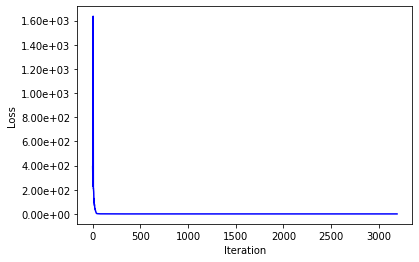

In [72]:
model = PDENet(xb, yb, tb, ub, xi, yi, ti, ui, x, y, t, layers)
# model = PDENet(xb, yb, tb, ub, x, y, t, layers)
start_time = time.time()                
model.train(0)
elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))
losses = np.array(model.lossHistogram)
losses = losses.reshape(len(losses))
epochs = losses.size
x_epochs = [i + 1 for i in range(epochs)]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_epochs,losses, color = 'blue')
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.setp(ax, xlabel='Iteration')
plt.setp(ax, ylabel='Loss')
plt.show()

a_file = open("Loss21.txt", "w")
for row in np.array(model.lossHistogram).reshape(len(model.lossHistogram), 1):
    np.savetxt(a_file, row)
a_file.close()

In [73]:
a_file = open("Loss21.txt", "w")
for row in np.array(model.lossHistogram).reshape(len(model.lossHistogram), 1):
    np.savetxt(a_file, row)
a_file.close()

In [ ]:
epochs

2593

In [74]:
def exact_solution(x, y, t):
    u = tf.math.exp(t)*tf.math.sin(np.pi*x)*tf.math.sin(np.pi*y)
    return u

In [ ]:
def flatArr(x):
    y = []
    for row in x:
        for el in row:
            y.append(el)
    return np.array(y).flatten()

def splitData(data):
    x = []
    y = []
    xb = []
    yb = []
    ub = []
    u = []
    for row in data:
        if (row[0] == 0. or row[1] == 0. or row[0] == 1. or row[1] == 1.):
            xb.append(row[0])
            yb.append(row[1])
            ub.append(0.0)
        else:
            x.append(row[0])
            y.append(row[1])
            u.append(round(np.sin(np.pi*row[0])*np.sin(np.pi*row[1]), 6))
    return np.array(x), np.array(y), np.array(u), np.array(xb), np.array(yb), np.array(ub)

def sample(T, delta_t, data):
    xi,yi,ui,xb,yb,ub = splitData(data)
    x_arr = np.array([])
    y_arr = np.array([])
    NT = np.int(T/delta_t)
    t = []
    for i in range(NT):
        t.append([round((i+1)*delta_t,6) for e in range(xi.size)])
        x_arr = np.concatenate((x_arr, xi))
        y_arr = np.concatenate((y_arr, yi))
    t = flatArr(t)
    tb = []
    xb_arr = np.array([])
    yb_arr = np.array([])
    for i in range(NT+1):
        tb.append([round(i*delta_t,6) for e in range(xb.size)])
        xb_arr = np.concatenate((xb_arr, xb))
        yb_arr = np.concatenate((yb_arr, yb))
    tb = flatArr(tb)
    ti = np.array([0.0 for e in range(xi.size)])
    ub = np.array([0.0 for e in xb_arr])

    return x_arr, y_arr, t, xi, yi, ti, ui, xb_arr, yb_arr, tb, ub

In [ ]:
dataset = np.genfromtxt('triangle_data_10_10.txt', delimiter=',')
x, y, t, xi, yi, ti, ui, xb, yb, tb, ub = sample(1.0, 0.1, dataset)
x = x.reshape((x.size, 1, 1))
y = y.reshape((y.size, 1, 1))
t = t.reshape((t.size, 1, 1))
xb = xb.reshape((xb.size, 1, 1))
yb = yb.reshape((yb.size, 1, 1))
tb = tb.reshape((tb.size, 1, 1))
ub = ub.reshape((ub.size, 1))
xi = xi.reshape((xi.size, 1, 1))
yi = yi.reshape((yi.size, 1, 1))
ti = ti.reshape((ti.size, 1, 1))
ui = ui.reshape((ui.size, 1))


In [75]:
dataset = np.genfromtxt('data_2000.csv', delimiter=',')
# x, y, xb, yb, ub, vb = splitData(dataset)
x = dataset[:,0]
x = x.reshape((x.size, 1, 1))
y = dataset[:,1]
y = y.reshape((y.size, 1, 1))
t = dataset[:,2]
t = t.reshape((t.size, 1, 1))
xb = dataset[:,3]
xb = xb.reshape((xb.size, 1, 1))
yb = dataset[:,4]
yb = yb.reshape((yb.size, 1, 1))
tb = dataset[:,5]
tb = tb.reshape((tb.size, 1, 1))
ub = dataset[:,6]
ub = ub.reshape((ub.size, 1))
xi = dataset[:,7]
xi = xi.reshape((xi.size, 1, 1))
yi = dataset[:,8]
yi = yi.reshape((yi.size, 1, 1))
ti = dataset[:,9]
ti = ti.reshape((ti.size, 1, 1))
ui = dataset[:,10]
ui = ui.reshape((ui.size, 1))

In [76]:
u_e = exact_solution(x, y, t)
u_e = tf.reshape(u_e, [x.size, 1])
u_pred = model.predict(x, y, t)
ub_pred = model.predict(xb, yb, tb)
ui_pred = model.predict(xi, yi, ti)

In [77]:
LossL2 = tf.reduce_mean(tf.square(u_pred - u_e)) + tf.reduce_mean(tf.square(ub_pred - ub)) + tf.reduce_mean(tf.square(ui_pred - ui))
with tf.Session() as sess:
    result = LossL2.eval()

    print(result) 

    print(type(result))

0.00011957960237262262
<class 'numpy.float64'>


In [78]:
LossL2= tf.math.sqrt(LossL2)
with tf.Session() as sess:
    result = LossL2.eval()

    print(result) 

    print(type(result))

0.010935245876185072
<class 'numpy.float64'>
